In [1]:
import numpy as np
from operator import itemgetter
import os
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(1)
import matplotlib.pyplot as plt

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [9]:
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

In [7]:
import os
os.chdir('/scratch/wpg205')
os.getcwd()


#loading Fasttext word embeddings
ft_home = './'
words_to_load = 50000

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    ordered_words_ft.append(PAD_IDX)
    ordered_words_ft.append(UNK_IDX)
    for t, line in enumerate(f):
        i = t + 2 
        if t >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i, :] = np.asarray(s[1:])
        words_ft[s[0]] = i
        idx2words_ft[i] = s[0]
        ordered_words_ft.append(s[0])

loaded_embeddings_ft_torch = torch.tensor(loaded_embeddings_ft, requires_grad = True)
del loaded_embeddings_ft

In [6]:
#test
print(ordered_words_ft[words_ft['the']])
print(ordered_words_ft[words_ft['test']])
print(ordered_words_ft[words_ft['is']])
print(ordered_words_ft[words_ft['passed']])

the
test
is
passed


In [7]:
#with open('snli_train.tsv') as f:
snli_train = pd.read_csv('snli_train.tsv', sep='\t') 
#snli_train = snli_train.iloc[:10000,:]
snli_train['sentence1'] = snli_train['sentence1'].str.split()
snli_train['sentence2'] = snli_train['sentence2'].str.split()

snli_val = pd.read_csv('snli_val.tsv', sep='\t') 
#snli_val = snli_val.iloc[:10000,:]
snli_val['sentence1'] = snli_val['sentence1'].str.split()
snli_val['sentence2'] = snli_val['sentence2'].str.split()

snli_train['label'].replace('neutral',0, inplace=True)
snli_train['label'].replace('entailment',1, inplace = True)
snli_train['label'].replace('contradiction',2, inplace = True)

snli_val['label'].replace('neutral',0, inplace=True)
snli_val['label'].replace('entailment',1, inplace = True)
snli_val['label'].replace('contradiction',2, inplace = True)

data_tup_train = zip(snli_train.sentence1,snli_train.sentence2,snli_train.label)
data_tup_val = zip(snli_val.sentence1,snli_val.sentence2,snli_val.label)

del snli_train
del snli_val

In [8]:
Max_sen_length = 82

class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, char2id):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.sent1,self.sent2,self.target_list = zip(*data_tuple)
        assert (len(self.sent1) == len(self.target_list))
        assert (len(self.sent2) == len(self.target_list))
        self.char2id = char2id

    def __len__(self):
        return len(self.sent1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        char_idx_1 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.sent1[key][:Max_sen_length]]
        char_idx_2 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.sent2[key][:Max_sen_length]]
        label = self.target_list[key]
        return [char_idx_1, char_idx_2,len(char_idx_1),len(char_idx_2),label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list = []
    length_list_2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list.append(datum[2])
        length_list_2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]),
                                pad_width=((0,Max_sen_length-datum[2])),
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[1]),
                                pad_width=((0,Max_sen_length-datum[3])),
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec1)
        data_list_2.append(padded_vec2)
    
    ordering1 = np.linspace(0, len(data_list_1),len(data_list_1), endpoint = False)
    ordering2 = np.linspace(0, len(data_list_2),len(data_list_2), endpoint = False)
      
    ind_dec_order = np.argsort(length_list)[::-1]
    ind_dec_order_2 = np.argsort(length_list_2)[::-1]
    
    ordering1 = ordering1[ind_dec_order]
    ordering2 = ordering2[ind_dec_order_2]
        
    data_list_1 = np.array(data_list_1)[ind_dec_order]
    data_list_2 = np.array(data_list_2)[ind_dec_order_2]
                
    length_list = np.array(length_list)[ind_dec_order]
    length_list_2 = np.array(length_list_2)[ind_dec_order_2]
    
                
    #label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(data_list_1)), torch.from_numpy(np.array(data_list_2)), \
            torch.LongTensor(length_list),torch.LongTensor(length_list_2), \
            torch.LongTensor(label_list), ordering1, ordering2]


In [9]:
train_dataset = VocabDataset(data_tup_train, words_ft)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(data_tup_val, words_ft)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

del train_dataset
del val_dataset

In [3]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, bidirectional = True):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        #self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding = nn.Embedding.from_pretrained(loaded_embeddings_ft_torch, freeze = False).to(device)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional = True).to(device)
        self.linear1 = nn.Linear(hidden_size*2*2, 100).to(device)
        self.linear2 = nn.Linear(100, 50).to(device)
        self.linear = nn.Linear(50, num_classes).to(device)
        #self.linear = nn.Linear(hidden_size*2*2, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden.to(device)

    def forward(self, x1,x2,lengths1,lengths2, ordering1, ordering2):
        #setting mask
        """"""
        m1 = torch.zeros([x1.size(0), x1.size(1)]).to(device)
        m2 = torch.zeros([x2.size(0), x2.size(1)]).to(device)
        
        m1[x1 == 1] = 1
        m2[x2 == 1] = 1
    
        #m1 = torch.from_numpy(m1)
        #m2 = torch.from_numpy(m2)
        
        
        # reset hidden state
        batch_size, seq_len = x1.size()

        # get embedding of characters
        embed1 = self.embedding(x1.to(device))
        embed2 = self.embedding(x2.to(device))
        
        m1 = m1.unsqueeze(-1).expand_as(embed1).to(device)
        m2 = m2.unsqueeze(-1).expand_as(embed2).to(device)
        embed1 = embed1.to(torch.float).to(device)
        embed2 = embed2.to(torch.float).to(device)
        m1 = m1.to(torch.float).to(device)
        m2 = m2.to(torch.float).to(device)

        embed1 = m1 * embed1+ (1-m1) * embed1.clone().detach()
        embed2 = m2 * embed2+ (1-m2) * embed2.clone().detach()
        
        
        # pack padded sequence
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, lengths1.numpy(), batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, lengths2.numpy(), batch_first=True)
        
        
        # fprop though RNN
        self.hidden = self.init_hidden(batch_size).to(device)
        rnn_out1, self.hidden1 = self.rnn(embed1, self.hidden)
        
        # undo packing
        rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        
        # fprop though RNN
        self.hidden = self.init_hidden(batch_size).to(device)
        rnn_out2, self.hidden2 = self.rnn(embed2, self.hidden)
        # undo packing
        rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        """        
        # fprop though RNN
        self.hidden = self.init_hidden(batch_size)
        rnn_out1, self.hidden1 = self.rnn(embed1, self.hidden)
        
        # fprop though RNN
        self.hidden = self.init_hidden(batch_size)
        rnn_out2, self.hidden2 = self.rnn(embed2, self.hidden)
        """
        reverse1 = np.argsort(ordering1)
        reverse2 = np.argsort(ordering2)
        #print(rnn_out1.size())
        #Use hidden state rather than the last one
        
        
        rnn_out1 = rnn_out1[reverse1,:,:].to(device)
        rnn_out2 = rnn_out2[reverse2,:,:].to(device)
        
        #self.hidden1 = self.hidden1[:,reverse1,:]
        #self.hidden2 = self.hidden2[:,reverse2,:]
        #print(rnn_out1)
        #print(rnn_out2.size())
        
        # sum hidden activations of RNN across time
        rnn_out1 = torch.sum(rnn_out1, dim=1).to(device)
        rnn_out2 = torch.sum(rnn_out2, dim=1).to(device)
        #rnn_out1 = rnn_out1[:,-1,:]
        #rnn_out2 = rnn_out2[:,-1,:]
        
        rnn_out = torch.cat((rnn_out1,rnn_out2), 1).to(device)
        #rnn_out = torch.cat((self.hidden1,self.hidden2), 2)

        rnn_out = F.relu(self.linear1(rnn_out))
        rnn_out = F.relu(self.linear2(rnn_out))
        logits = self.linear(rnn_out)
        return logits


In [37]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    total_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data1,data2,lengths1,lengths2,labels,ordering1,ordering2 in loader:
            outputs = F.softmax(model(data1,data2, lengths1,lengths2,ordering1,ordering2), dim=0)
            predicted = outputs.max(1, keepdim=True)[1]
            loss = criterion(outputs, labels.to(device))
            total_loss += loss/labels.size(0)
            total += labels.size(0)
            correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
        return (100 * correct / total), total_loss

In [38]:
model = GRU(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, vocab_size=words_to_load)

learning_rate = 3e-4
num_epochs = 8 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

train_loss_vals = []
train_acc_vals = []
val_loss_vals = []
val_acc_vals = []
for epoch in range(num_epochs):
    for i, (data1,data2,lengths1,lengths2,labels,ordering1,ordering2) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1,data2,lengths1,lengths2,ordering1,ordering2)
        #print(outputs,labels)
        loss = criterion(outputs,labels.to(device))
        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 1000 == 0:
            # validate
            print("total lossing")
            val_acc, val_loss = test_model(val_loader, model)
            train_acc, train_loss = test_model(train_loader, model)
            train_loss_vals.append(train_loss)
            train_acc_vals.append(train_acc)
            val_loss_vals.append(val_loss)
            val_acc_vals.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}'.format(
                       epoch+1, num_epochs, i+1, total_step, val_acc, train_acc ))


total lossing
Epoch: [1/8], Step: [1001/3125], Validation Acc: 50.2, Train Acc: 51.125
total lossing
Epoch: [1/8], Step: [2001/3125], Validation Acc: 54.4, Train Acc: 53.916
total lossing
Epoch: [1/8], Step: [3001/3125], Validation Acc: 56.1, Train Acc: 55.702
total lossing
Epoch: [2/8], Step: [1001/3125], Validation Acc: 53.1, Train Acc: 56.319
total lossing
Epoch: [2/8], Step: [2001/3125], Validation Acc: 57.1, Train Acc: 57.061
total lossing
Epoch: [2/8], Step: [3001/3125], Validation Acc: 58.8, Train Acc: 57.577
total lossing
Epoch: [3/8], Step: [1001/3125], Validation Acc: 58.2, Train Acc: 58.379
total lossing
Epoch: [3/8], Step: [2001/3125], Validation Acc: 59.4, Train Acc: 59.417
total lossing
Epoch: [3/8], Step: [3001/3125], Validation Acc: 59.4, Train Acc: 60.446
total lossing
Epoch: [4/8], Step: [1001/3125], Validation Acc: 60.7, Train Acc: 60.68
total lossing
Epoch: [4/8], Step: [2001/3125], Validation Acc: 59.4, Train Acc: 61.387
total lossing
Epoch: [4/8], Step: [3001/3125

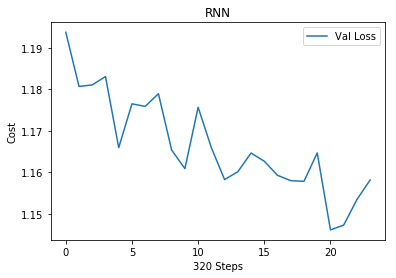

In [44]:
plt.clf()
fig = plt.figure()
plt.title('RNN')
plt.xlabel('320 Steps')
plt.ylabel('Cost')
#plt.plot(train_loss_vals, label='Train Loss')
plt.plot(val_loss_vals, label='Val Loss')
plt.legend(loc='best')
fig.savefig('RNN_1_val.png')

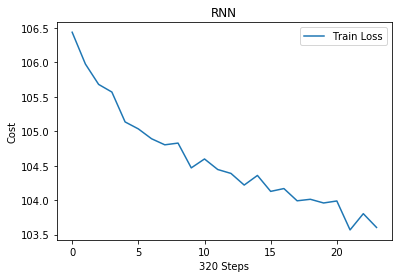

In [45]:
plt.clf()
fig = plt.figure()
plt.title('RNN')
plt.xlabel('320 Steps')
plt.ylabel('Cost')
plt.plot(train_loss_vals, label='Train Loss')
#plt.plot(val_loss_vals, label='Val Loss')
plt.legend(loc='best')
fig.savefig('RNN_1_train.png')

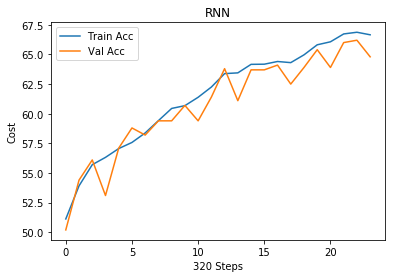

In [46]:
plt.clf()
fig = plt.figure()
plt.title('RNN')
plt.xlabel('320 Steps')
plt.ylabel('Cost')
plt.plot(train_acc_vals, label='Train Acc')
plt.plot(val_acc_vals, label='Val Acc')
plt.legend(loc='best')
fig.savefig('RNN_1_accs.png')

In [5]:
def total_params(model):
    param_total = 0
    for x in model.parameters():
        if x.requires_grad:
            store = 1
            for y in range(len(x.size())):
                store = store*x.size(y)
            param_total += store
    
    #(these are untrained embeddings)
    total_embeddings = 50001*300
    param_total -= total_embeddings
    return param_total



In [10]:
model_params = GRU(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, vocab_size=words_to_load)

In [11]:
total_params(model_params)

688003